In [2]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cargar los datos

In [38]:
ruta_al_archivo = 'datos_telecom_preprocesado_1.csv'  # Modifica según sea necesario
data = pd.read_csv(ruta_al_archivo)

In [39]:
data.head()

,ID,Genero,Casado,Edad,Graduado,Profesion,Experiencia laboral,Gastoscore,Family_Size,anno_nacimiento,Generacion,ingresos_anuales_brutos,Provincia,Digital_encuesta,Gasto_medio_mensual_cuota,Abandono,Dias_cliente,Campanna_anno
0,CLI2,1,0,-1.297819,0,3,2,-0.151048,0.798110,1.298075,2,-1.189304,28,-0.332995,-0.533086,0,-0.134417,-0.712814
1,CLI3,0,1,-0.321216,1,4,0,1.465015,0.152186,0.321457,3,1.748442,35,0.031565,-0.533086,0,1.054800,1.328800
2,CLI4,0,1,1.414966,1,4,0,-0.151048,-1.139662,-1.414753,1,-0.072779,6,-0.190716,0.164441,0,0.550894,-0.032276
3,CLI5,1,1,1.414966,1,8,0,-1.767111,-0.493738,-1.414753,1,0.737793,14,-0.452758,0.164441,1,0.597925,1.328800
4,CLI6,0,1,-0.212705,1,7,0,-1.767111,2.089958,0.212944,1,0.977609,49,0.020547,-0.533086,1,0.006676,-0.712814


# 3. Selección de características

In [40]:
# Para simplificar, usamos todas las columnas numéricas
X = data.drop(columns=['ID'])

# 4. Determinación del número óptimo de clusters

In [41]:
wcss = []
silhouette_scores = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

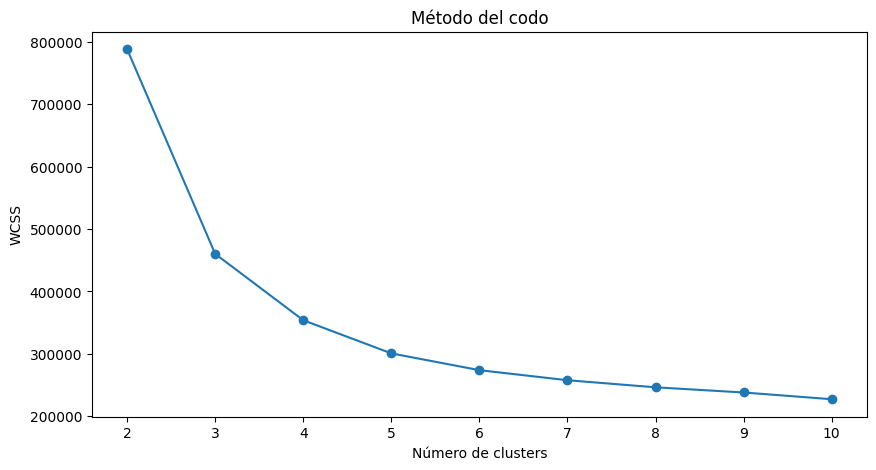

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

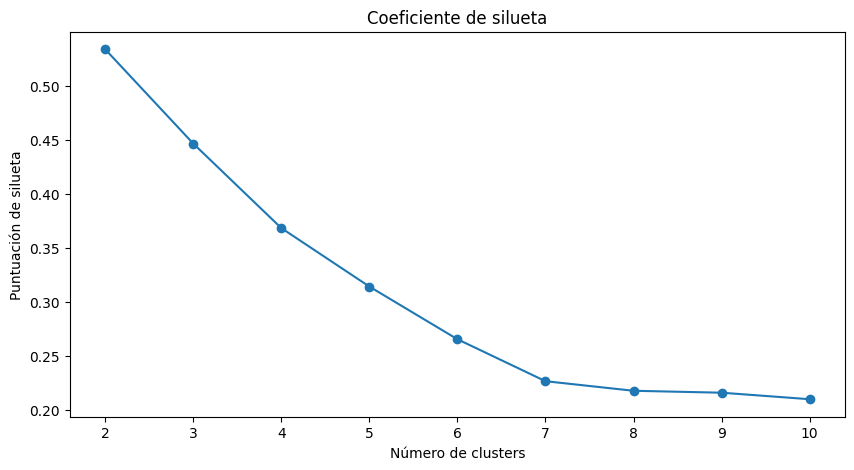

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Coeficiente de silueta')
plt.xlabel('Número de clusters')
plt.ylabel('Puntuación de silueta')
plt.show()

In [67]:
n_clusters_optimo = 4

# 5. Entrenamiento del modelo K-Means

In [68]:
kmeans = KMeans(n_clusters=n_clusters_optimo, random_state=42)
data['Cluster'] = kmeans.fit_predict(X)

# 6. Verificación del modelo

In [69]:
# Coeficiente de silueta
# Índice Calinski-Harabasz
# Índice Davies-Bouldin (valores más bajos son mejores)
silhouette_avg = silhouette_score(X, data['Cluster'])
calinski_score = calinski_harabasz_score(X, data['Cluster'])
davies_bouldin = davies_bouldin_score(X, data['Cluster'])
print(f'Coeficiente de silueta promedio: {silhouette_avg:.2f}')
print(f'Índice de Calinski-Harabasz: {calinski_score:.2f}')
print(f'Índice Davies-Bouldin: {davies_bouldin:.2f}')

Coeficiente de silueta promedio: 0.37
Índice de Calinski-Harabasz: 21319.26
Índice Davies-Bouldin: 0.89


In [70]:
# Verificar distribución de clusters
cluster_counts = data['Cluster'].value_counts()
print("\nDistribución de puntos por cluster:")
print(cluster_counts)


Distribución de puntos por cluster:
Cluster
2    2846
0    2716
1    2625
3    2619
Name: count, dtype: int64


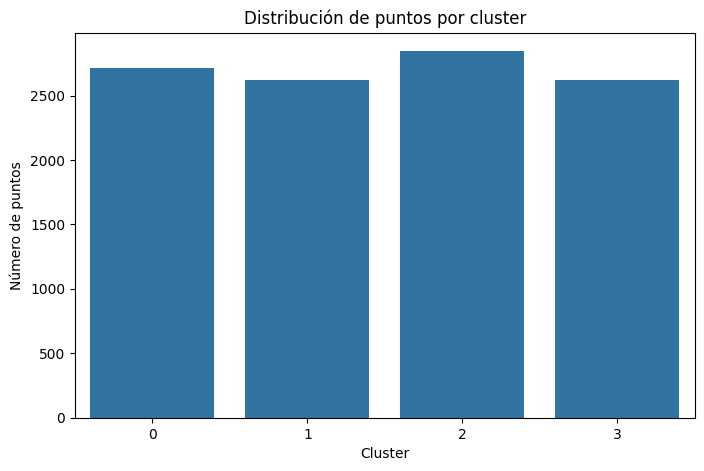

In [71]:
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.title('Distribución de puntos por cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de puntos')
plt.show()

In [72]:
# Validación visual con PCA para reducir dimensiones
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
data['PCA1'], data['PCA2'] = X_pca[:, 0], X_pca[:, 1]

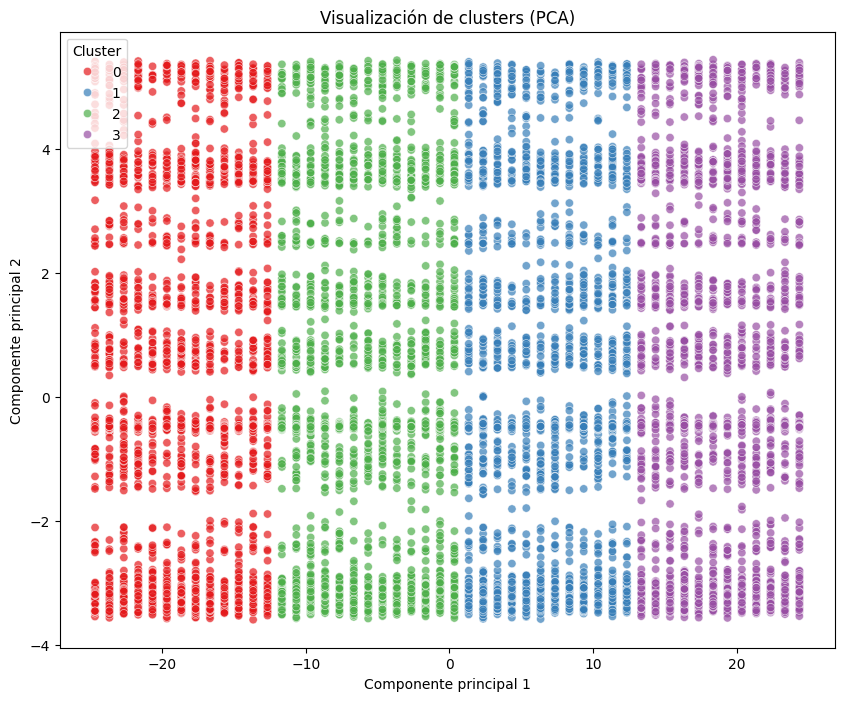

In [73]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', alpha=0.7)
plt.title('Visualización de clusters (PCA)')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.legend(title='Cluster')
plt.show()

In [74]:
from sklearn.metrics import silhouette_samples

# Función para graficar las siluetas
def plot_silhouette(X, labels, n_clusters):
    silhouette_vals = silhouette_samples(X, labels)
    y_lower, y_upper = 0, 0
    yticks = []

    plt.figure(figsize=(10, 7))
    for i in range(n_clusters):
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        yticks.append((y_lower + y_upper) / 2)
        y_lower += len(cluster_silhouette_vals)

    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, [f'Cluster {i}' for i in range(n_clusters)])
    plt.ylabel("Clusters")
    plt.xlabel("Coeficiente de silueta")
    plt.title("Gráfico de Silueta")
    plt.show()


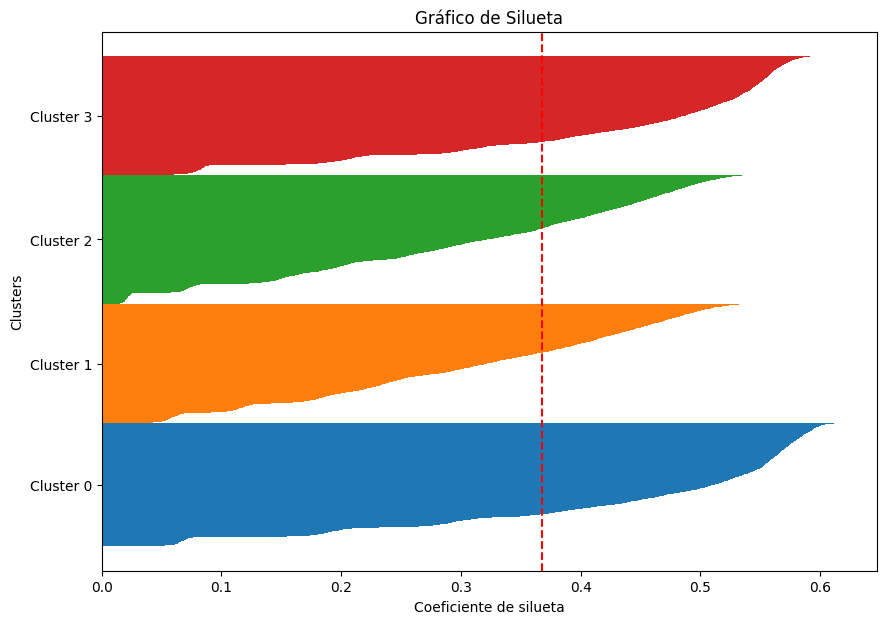

In [75]:
# Graficar las siluetas
plot_silhouette(X, data['Cluster'].values, n_clusters_optimo)